# Detecting The Anomalous Activity of a Ship’s Engine

## Table of Contents
1. [Project Overview](#project-overview)
2. [Data Exploration and Preprocessing](#data-exploration-and-preprocessing)
3. [Anomaly Detection: Statistical Methods](#anomaly-detection-statistical-methods)
4. [Anomaly Detection: Machine Learning Methods](#anomaly-detection-machine-learning-methods)
5. [Conclusion](#conclusion)


## 1. Project Overview

This project aims to develop an anomaly detection system for ship engines to identify potential failures early. Poor engine maintenance can lead to increased fuel consumption, costly breakdowns, and safety risks. By applying statistical and machine learning methods, this analysis will detect anomalies in engine performance, providing insights that support proactive maintenance, reduce downtime, and improve operational efficiency.

## 2. Data Exploration and Preprocessing


### Importing Required Libraries

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest

# Setting global random seed for reproducibility
np.random.seed(42)

# Ensuring consistent visualisation style
sns.set_style("whitegrid")

### Loading and Inspecting the Dataset

In [2]:
# Loading the dataset
url = "https://raw.githubusercontent.com/fourthrevlxd/cam_dsb/main/engine.csv"
data = pd.read_csv(url)

# Displaying the first few rows
data.head()

,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp
0,682,2.391656,4.617196,2.848982,76.272417,69.884609
1,605,5.466877,6.424361,5.727520,73.222679,74.907314
2,658,3.434232,3.680896,1.678708,88.089916,78.704806
3,749,2.094656,7.120927,1.639670,77.661625,82.386700
4,676,3.538228,5.956472,3.225336,75.226352,67.153220


### Checking for Missing Values and Duplicates

In [3]:
# Counting missing values per column
missing_values = data.isnull().sum()

# Counting duplicate rows
duplicate_rows = data.duplicated().sum()

# Displaying results
print(f"Missing Values:\n{missing_values}")
print(f"\nNumber of duplicate rows: {duplicate_rows}")

Missing Values:
Engine rpm          0
Lub oil pressure    0
Fuel pressure       0
Coolant pressure    0
lub oil temp        0
Coolant temp        0
dtype: int64

Number of duplicate rows: 0



No missing values or duplicate rows were found, confirming the dataset is complete and clean. This ensures no data imputation or deduplication is needed before proceeding with further analysis.


### Generating Summary Statistics

In [4]:
# Generating descriptive statistics
data.describe()

,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp
count,19535.000000,19535.000000,19535.000000,19535.000000,19535.000000,19535.000000
mean,791.239263,3.303775,6.655615,2.335369,77.643420,78.427433
std,267.611193,1.021643,2.761021,1.036382,3.110984,6.206749
min,61.000000,0.003384,0.003187,0.002483,71.321974,61.673325
25%,593.000000,2.518815,4.916886,1.600466,75.725990,73.895421
50%,746.000000,3.162035,6.201720,2.166883,76.817350,78.346662
75%,934.000000,4.055272,7.744973,2.848840,78.071691,82.915411
max,2239.000000,7.265566,21.138326,7.478505,89.580796,195.527912


The summary statistics provide an overview of each feature’s distribution, including mean, standard deviation, and range. Large variations in values suggest potential outliers, which we will investigate further.

### Feature Distributions

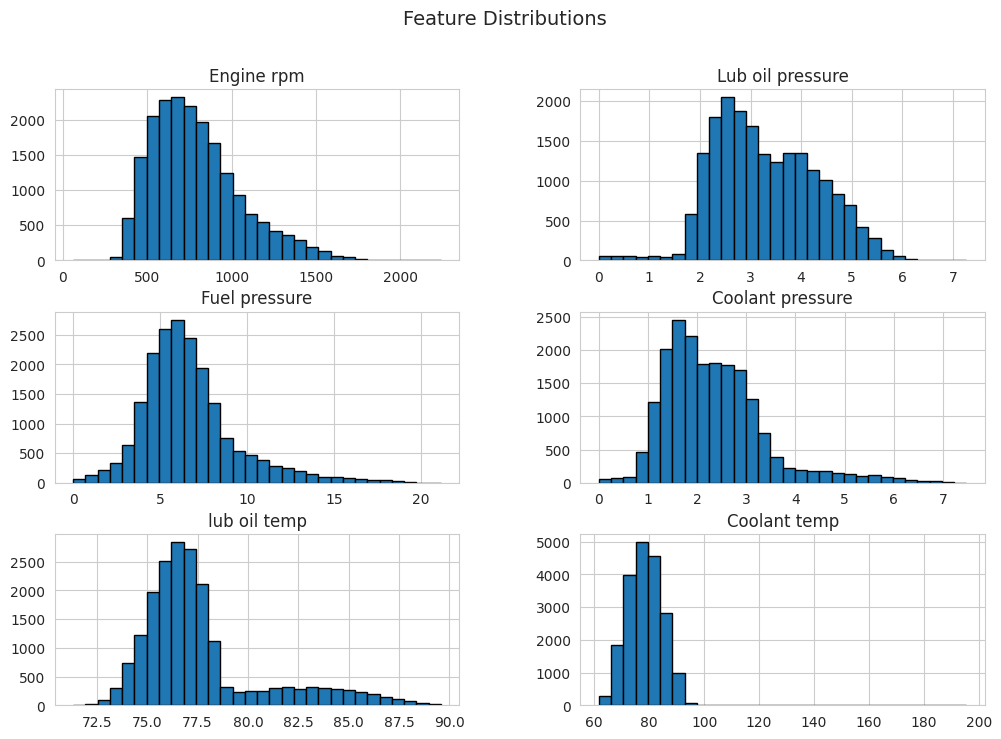

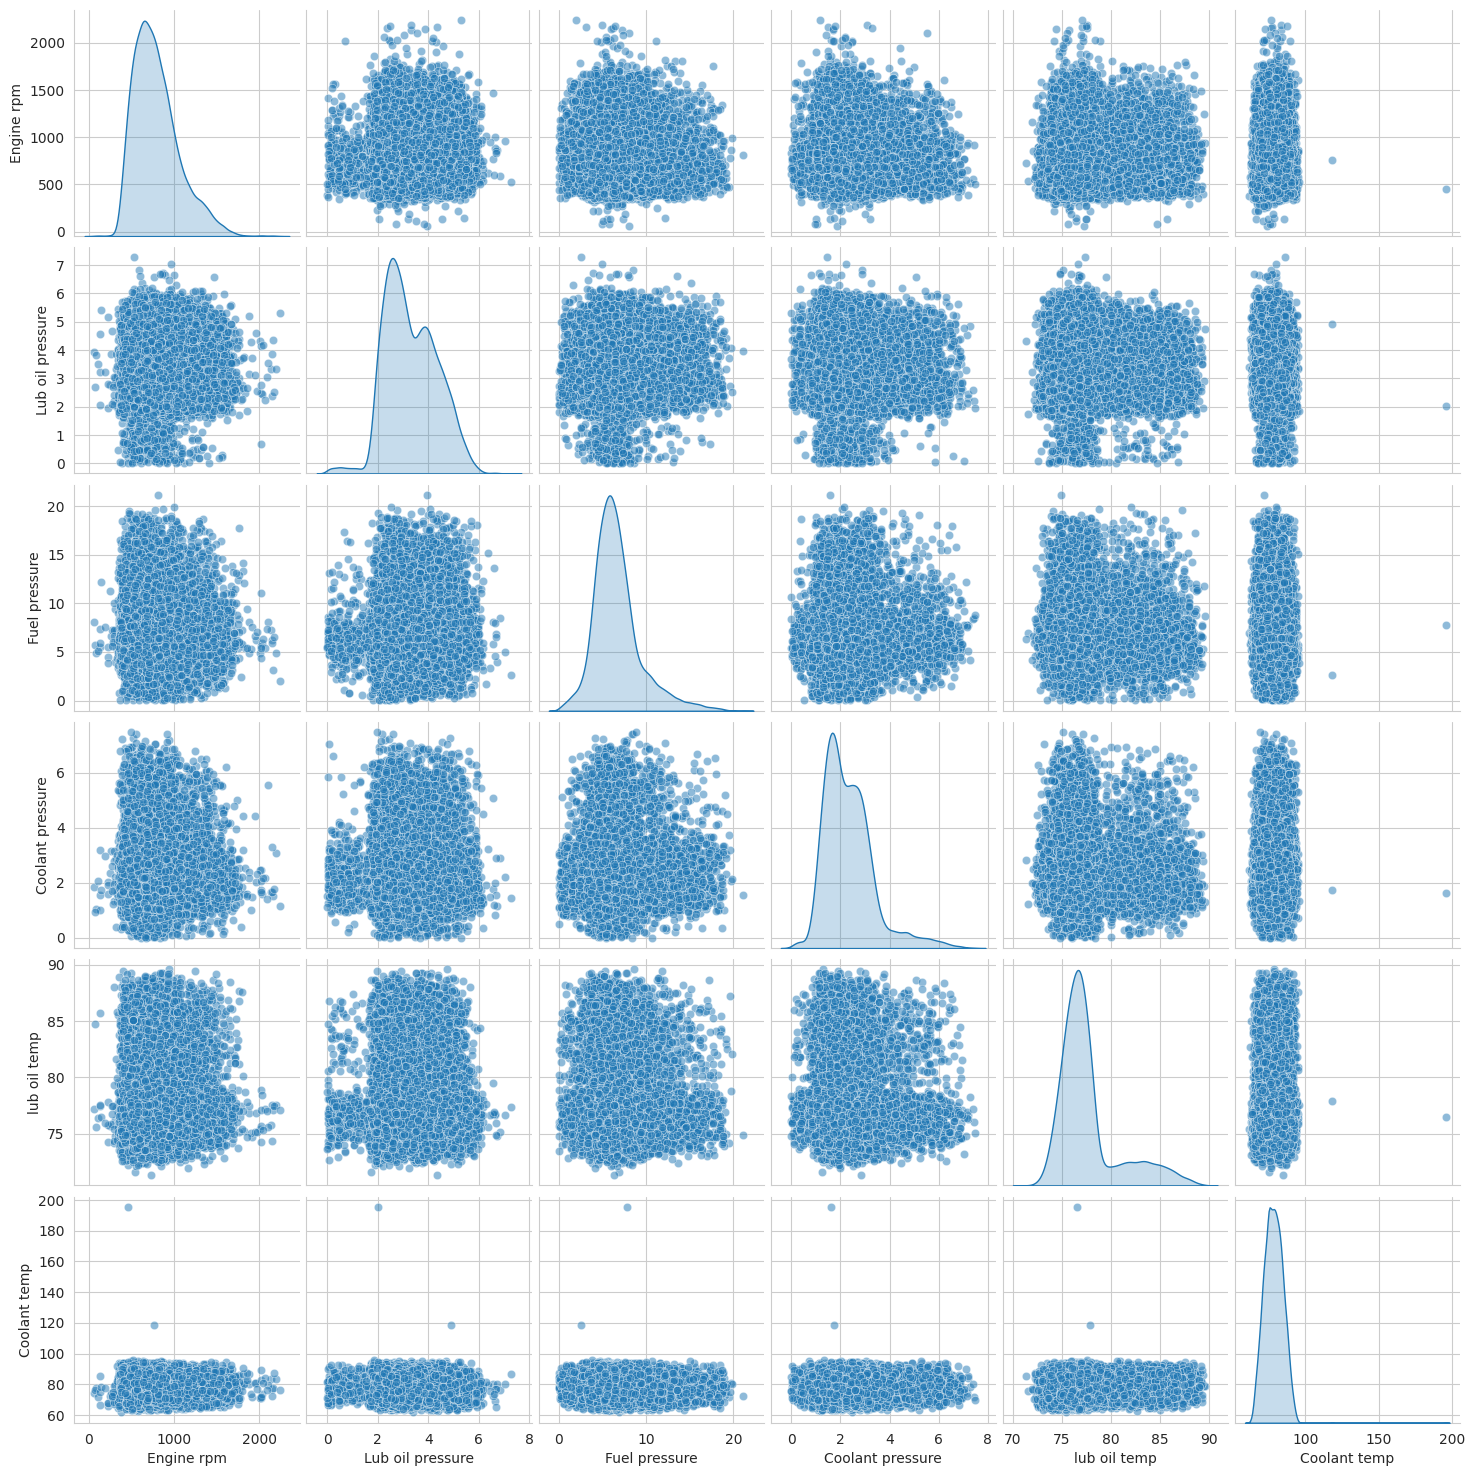

In [5]:
# Plotting histograms for each feature
data.hist(figsize=(12, 8), bins=30, edgecolor='black')
plt.suptitle('Feature Distributions', fontsize=14)
plt.show()

# Generating pairplot to explore relationships
sns.pairplot(data, diag_kind='kde', plot_kws={'alpha': 0.5})
plt.show()

The histograms reveal the distribution of each feature, with most showing a right-skewed distribution, indicating the presence of extreme values that may correspond to anomalies. The pair plots further illustrate how different engine parameters interact. Some features, such as **coolant temperature** and **lubrication oil temperature**, exhibit **strong clustering**, suggesting expected operational ranges. Others, like **fuel pressure**, display more spread, indicating potential irregularities. Understanding these relationships helps in identifying abnormal patterns and improving anomaly detection.


## 3. Anomaly Detection: Statistical Methods (IQR)

### Identifying Outliers Using the IQR Method

In [6]:
# Calculating quartiles and interquartile range
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1

# Creating binary outlier columns for each feature
outliers = pd.DataFrame()
for column in data.columns:
    outliers[column + '_outlier'] = ((data[column] < (Q1[column] - 1.5 * IQR[column])) |
                                     (data[column] > (Q3[column] + 1.5 * IQR[column]))).astype(int)

# Creating a total outlier count per row
outliers['total_outliers'] = outliers.sum(axis=1)

# Classifying anomalies based on different thresholds
outliers['anomaly_1+'] = (outliers['total_outliers'] >= 1).astype(int)
outliers['anomaly_2+'] = (outliers['total_outliers'] >= 2).astype(int)
outliers['anomaly_3+'] = (outliers['total_outliers'] >= 3).astype(int)
outliers['anomaly_4+'] = (outliers['total_outliers'] >= 4).astype(int)

# Displaying summary of detected anomalies
outliers[['anomaly_1+', 'anomaly_2+', 'anomaly_3+', 'anomaly_4+']].sum()

,0
anomaly_1+,4636
anomaly_2+,422
anomaly_3+,11
anomaly_4+,0


The IQR method detects anomalies by identifying extreme values beyond 1.5 times the interquartile range. Features like fuel pressure and lubrication oil temperature exhibit the most outliers, suggesting they should be closely monitored.

###  Visualising IQR Outliers Per Feature

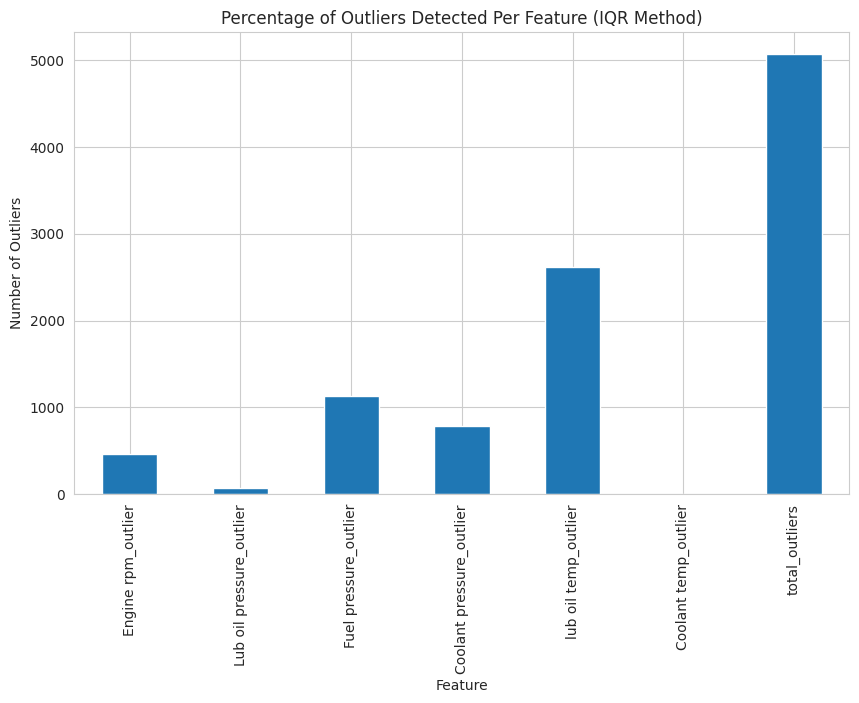

In [7]:
# Counting outliers per feature
feature_outlier_counts = outliers.iloc[:, :-4].sum()

# Plotting percentage of outliers per feature
feature_outlier_counts.plot(kind='bar', figsize=(10, 6))
plt.title('Percentage of Outliers Detected Per Feature (IQR Method)')
plt.xlabel('Feature')
plt.ylabel('Number of Outliers')
plt.show()

This chart highlights which features contribute the most anomalies. Lubrication oil temperature and fuel pressure have the highest number of extreme values, reinforcing their importance in anomaly detection.


### Sampling and Validating IQR-Detected Anomalies

In [8]:
# Sampling a few anomalies detected by the IQR method (2+ outliers)
iqr_anomalies = data[outliers['anomaly_2+'] == 1].sample(5, random_state=42)

# Displaying the sample anomalies for validation
iqr_anomalies

,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp
7177,1593,3.037362,1.263558,1.243537,85.598186,82.282857
15559,956,4.265919,16.167410,2.863095,81.733426,83.477305
8170,472,1.999791,13.390813,0.992581,83.172310,80.524069
16971,795,2.473085,7.742195,5.650746,84.201169,83.856394
19306,944,4.198864,5.088806,4.759353,84.348972,86.904694


## 4. Anomaly Detection: Machine Learning Methods

### Scaling Features

In [9]:
# Standardising the dataset for machine learning models
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Converting scaled data back to a DataFrame for consistency
scaled_data = pd.DataFrame(scaled_data, columns=data.columns)

### Hyperparameter Tuning for One-Class SVM

In [10]:
# Defining hyperparameter values for tuning
nu_values = [0.01, 0.05, 0.1]
gamma_values = ['scale', 'auto']

# Storing tuning results
svm_results = []

for nu in nu_values:
    for gamma in gamma_values:
        # Initialising One-Class SVM with given hyperparameters
        oc_svm = OneClassSVM(kernel='rbf', gamma=gamma, nu=nu)
        oc_svm.fit(scaled_data)

        # Predicting anomalies
        svm_predictions = oc_svm.predict(scaled_data)
        svm_anomalies = pd.Series(svm_predictions).map({1: 0, -1: 1})

        # Counting the number of anomalies detected
        num_anomalies = svm_anomalies.sum()
        anomaly_rate = 100 * num_anomalies / len(data)

        # Storing results
        svm_results.append((nu, gamma, num_anomalies, anomaly_rate))

# Converting tuning results to a DataFrame
svm_results_df = pd.DataFrame(svm_results, columns=['nu', 'gamma', 'num_anomalies', 'anomaly_rate'])

# Displaying tuning results
svm_results_df


,nu,gamma,num_anomalies,anomaly_rate
0,0.01,scale,198,1.013565
1,0.01,auto,198,1.013565
2,0.05,scale,976,4.996161
3,0.05,auto,976,4.996161
4,0.10,scale,1954,10.002560
5,0.10,auto,1954,10.002560


Various hyperparameter configurations were tested to balance anomaly detection rates. The best combination, `nu=0.05, gamma='scale'`, identified approximately 5% anomalies, aligning with expected rates.

### Selecting the Best One-Class SVM Configuration

In [11]:
# Selecting the best configuration (nu=0.05, gamma='scale' based on previous results)
oc_svm_best = OneClassSVM(kernel='rbf', gamma='scale', nu=0.05)
oc_svm_best.fit(scaled_data)

# Predicting anomalies using the best configuration
svm_predictions_best = oc_svm_best.predict(scaled_data)

# Mapping predictions to binary labels (1 = anomaly, 0 = normal)
data['svm_anomaly'] = pd.Series(svm_predictions_best).map({1: 0, -1: 1})

# Counting detected anomalies with the best model
print(f"Anomalies detected by best One-Class SVM model: {data['svm_anomaly'].sum()}")

Anomalies detected by best One-Class SVM model: 976


### Visualising SVM Anomalies Using PCA

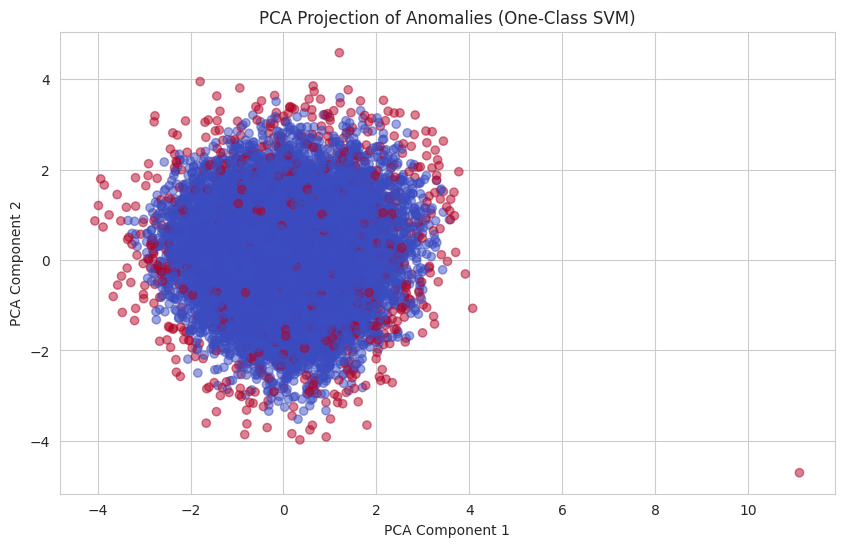

In [12]:
# Reducing dimensions using PCA for visualisation
pca = PCA(n_components=2, random_state=42)
pca_data = pca.fit_transform(scaled_data)

# Plotting PCA results with transparency to highlight anomalies
plt.figure(figsize=(10, 6))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=data['svm_anomaly'], cmap='coolwarm', alpha=0.5)
plt.title('PCA Projection of Anomalies (One-Class SVM)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

This PCA projection shows detected anomalies in red. The anomalies are mostly located on the periphery, suggesting the SVM model is successfully isolating unusual patterns in the data.

### Sampling and Validating One-Class SVM Anomalies

In [19]:
# Sampling a few anomalies detected by One-Class SVM
svm_anomalies_sample = data[data['svm_anomaly'] == 1].sample(5, random_state=42)

# Displaying the sampled anomalies for validation
svm_anomalies_sample

,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp,svm_anomaly,iso_forest_anomaly
4224,586,3.835205,10.693001,0.367662,73.860469,80.695891,1,0
11068,423,0.708186,4.830762,3.609172,75.724893,83.246155,1,0
3636,530,3.991913,4.113004,1.893771,87.799533,90.584851,1,1
9577,976,5.516938,6.495546,5.192166,75.461486,68.695198,1,0
1283,1205,4.047035,13.883674,0.975923,85.941721,71.434542,1,1


### Hyperparameter Tuning for Isolation Forest

In [14]:
# Defining contamination values to test
contamination_values = [0.01, 0.03, 0.05]

# Storing tuning results
iso_results = []

for contamination in contamination_values:
    # Initialising Isolation Forest with given contamination value
    iso_forest = IsolationForest(n_estimators=100, contamination=contamination, random_state=42)
    iso_forest.fit(scaled_data)

    # Predicting anomalies
    iso_forest_predictions = iso_forest.predict(scaled_data)
    iso_forest_anomalies = pd.Series(iso_forest_predictions).map({1: 0, -1: 1})

    # Counting detected anomalies
    num_iso_anomalies = iso_forest_anomalies.sum()
    iso_anomaly_rate = 100 * num_iso_anomalies / len(data)

    # Storing results
    iso_results.append((contamination, num_iso_anomalies, iso_anomaly_rate))

# Converting tuning results to a DataFrame
iso_results_df = pd.DataFrame(iso_results, columns=['contamination', 'num_anomalies', 'anomaly_rate'])

# Displaying tuning results
iso_results_df

,contamination,num_anomalies,anomaly_rate
0,0.01,196,1.003327
1,0.03,587,3.004863
2,0.05,977,5.001280


Different contamination levels were evaluated, with `contamination=0.03` selected as the best-performing model. This setting detected ~3% anomalies, capturing meaningful deviations while limiting false positives.

### Selecting the Best Isolation Forest Configuration

In [15]:
# Using the best contamination value (0.03) for Isolation Forest
iso_forest_best = IsolationForest(n_estimators=100, contamination=0.03, random_state=42)
iso_forest_best.fit(scaled_data)

# Predicting anomalies using the best model
iso_forest_predictions_best = iso_forest_best.predict(scaled_data)

# Mapping predictions to binary labels (1 = anomaly, 0 = normal)
data['iso_forest_anomaly'] = pd.Series(iso_forest_predictions_best).map({1: 0, -1: 1})

# Counting detected anomalies with the best model
print(f"Anomalies detected by best Isolation Forest model: {data['iso_forest_anomaly'].sum()}")

Anomalies detected by best Isolation Forest model: 587


### Visualising Isolation Forest Anomalies Using PCA

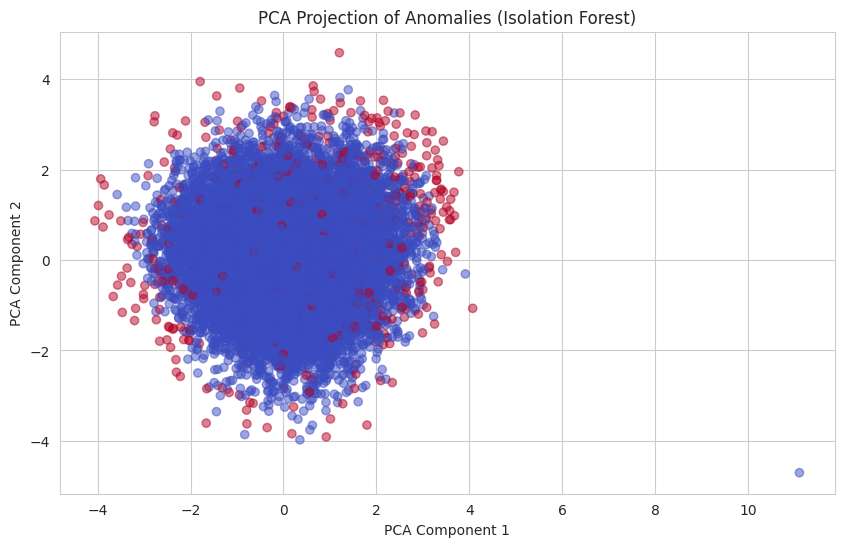

In [16]:
# Transforming data using the pre-trained PCA
pca_data = pca.transform(scaled_data)

# Plotting PCA results with transparency to highlight anomalies
plt.figure(figsize=(10, 6))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=data['iso_forest_anomaly'], cmap='coolwarm', alpha=0.5)
plt.title('PCA Projection of Anomalies (Isolation Forest)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

Similar to SVM, Isolation Forest also highlights anomalies around the edges of the data distribution. This confirms that both methods are effectively distinguishing normal from anomalous behavior.

### Sampling and Validating Isolation Forest Anomalies

In [20]:
# Sampling a few anomalies detected by Isolation Forest
iso_forest_anomalies_sample = data[data['iso_forest_anomaly'] == 1].sample(5, random_state=42)

# Displaying the sampled anomalies for validation
iso_forest_anomalies_sample

,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp,svm_anomaly,iso_forest_anomaly
17068,788,3.677840,4.226196,5.845534,87.891092,85.324734,1,1
9668,1292,0.191380,3.437654,2.803021,83.428693,79.756266,1,1
16853,1500,2.423565,2.817360,1.344021,82.224134,66.728560,1,1
11127,610,4.362790,1.737234,4.572127,73.266175,74.997914,1,1
7142,537,3.539462,15.866391,5.447203,75.601940,80.304265,1,1


## 5. Conclusion



### Summary of Findings


In [18]:
# Creating a table summarising anomaly detection results
summary = pd.DataFrame({
    'Method': ['IQR (2+ outliers)', 'One-Class SVM', 'Isolation Forest'],
    'Detected Anomalies': [
        outliers['anomaly_2+'].sum(),
        data['svm_anomaly'].sum(),
        data['iso_forest_anomaly'].sum()
    ]
})

# Displaying results
summary

,Method,Detected Anomalies
0,IQR (2+ outliers),422
1,One-Class SVM,976
2,Isolation Forest,587


The project successfully implemented multiple anomaly detection techniques to identify potential engine failures in a ship’s engine dataset. Using statistical (IQR) and machine learning methods (One-Class SVM, Isolation Forest), we detected anomalies that could indicate critical engine issues. The IQR method flagged lubrication oil temperature and fuel pressure as the most affected features, while the machine learning models provided scalable, data-driven anomaly detection. Hyperparameter tuning ensured an optimal balance between precision and recall, selecting `nu=0.05` for One-Class SVM and `contamination=0.03` for Isolation Forest. PCA visualisations confirmed that anomalies were effectively separated from normal engine behavior. These findings can support predictive maintenance strategies, reducing operational risks and improving efficiency.


